In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl

# set font to 15
mpl.rcParams.update({'font.size': 15})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [3]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


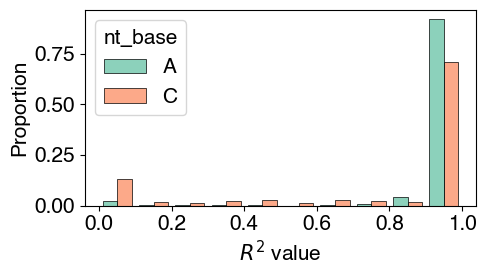

In [8]:
query= """SELECT
    log_kobs,
    log_kdeg,
    r2,
    nt_base,
    nt_site,
    construct_name
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained';
"""

df = read_sql(query)
df_melted = df.melt(id_vars=['nt_base', 'nt_site', 'construct_name'], value_vars=['log_kobs', 'log_kdeg', 'r2'], var_name='parameter', value_name='value')

# sort by base
bases = ['A', 'C']
df_melted['nt_base'] = pd.Categorical(df_melted['nt_base'], categories=bases, ordered=True)

# histplot for r2 grouped by base
plt.figure(figsize=(5, 3))
sns.histplot(data=df_melted[df_melted['parameter'] == 'r2'], x='value', hue='nt_base', multiple='dodge', stat = 'proportion', bins=10, shrink = 0.8, linewidth = 0.5, palette = 'Set2', common_norm = False)
plt.xlabel(r'$R^2$ value')
plt.ylabel('Proportion')
plt.tight_layout()
plt.savefig('exports/r2_dist_rd3_AC.pdf')
plt.show()

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_16890/2461156582.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_16890/2461156582.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{bin.right:.3f}" for bin in bins_order], rotation=45, ha='right')
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


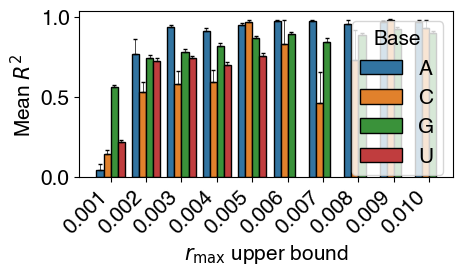

In [5]:
df = read_sql(query)
df['endpt'] = 1 - np.exp(-np.exp(df['log_kobs']))

bases = ['A', 'C', 'G', 'U']
df = df[df['nt_base'].isin(bases)].copy()

max_endpt = min(df['endpt'].max(), 0.01)
bins = np.linspace(0, max_endpt, 11)
df['endpt_bin'] = pd.cut(df['endpt'], bins=bins, include_lowest=True)
df['bin_label'] = df['endpt_bin'].apply(lambda x: f"{x.right:.4f}")

# mean + sem per (base, bin)
bin_stats = (
    df.groupby(['nt_base', 'endpt_bin'], observed=True)['r2']
      .agg(['mean', 'sem'])
      .reset_index()
      .rename(columns={'mean': 'r2_mean', 'sem': 'r2_sem'})
)

# lookup table for quick access
stat_lookup = bin_stats.set_index(['endpt_bin', 'nt_base'])

plt.figure(figsize=(5, 3))

# barplot without CI so we control error bars
width = 0.8  # must match what we assume below
ax = sns.barplot(
    data=bin_stats,
    x='endpt_bin',
    y='r2_mean',
    hue='nt_base',
    edgecolor='black',
    ci=None,
    width=width,
)

# compute x positions as seaborn does for hue-nested bars
x_positions = ax.get_xticks()
n_hue = len(bases)
bar_width = width / n_hue

# endpt_bin categories in x-axis order
bins_order = bin_stats['endpt_bin'].cat.categories

for j, endpt_bin in enumerate(bins_order):
    for k, base in enumerate(bases):
        key = (endpt_bin, base)
        if key in stat_lookup.index:
            y = stat_lookup.loc[key, 'r2_mean']
            sem = stat_lookup.loc[key, 'r2_sem']

            # center of this bar
            x = x_positions[j] - width/2 + bar_width/2 + k * bar_width

            # one-sided (upward) error bar
            ax.errorbar(
                x, y,
                yerr=[[0], [sem]],
                fmt='none',
                ecolor='black',
                elinewidth=0.5,
                capsize=1.5,
            )

# change x-tick labels to bin_label
ax.set_xticklabels([f"{bin.right:.3f}" for bin in bins_order], rotation=45, ha='right')

# clean legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(bases)], labels[:len(bases)], title='Base')

ax.set_xlabel(r'$r_{\max}$ upper bound')
ax.set_ylabel(r'Mean $R^2$')

# larger font everywhere

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('exports/r2_vs_endpt_by_base.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


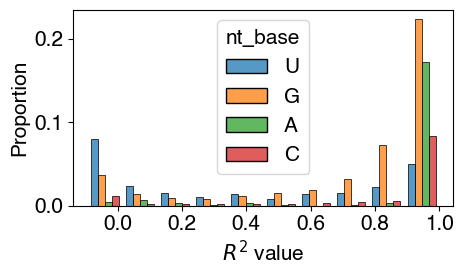

In [6]:
query= """SELECT
    log_kobs,
    log_kdeg,
    r2,
    nt_base,
    nt_site,
    construct_name
FROM probe_tc_fits_view
WHERE fit_kind = 'round1_free';
"""

df = read_sql(query)
df_melted = df.melt(id_vars=['nt_base', 'nt_site', 'construct_name'], value_vars=['log_kobs', 'log_kdeg', 'r2'], var_name='parameter', value_name='value')
# histplot for r2 grouped by base
plt.figure(figsize=(5, 3))
sns.histplot(data=df_melted[df_melted['parameter'] == 'r2'], x='value', hue='nt_base', multiple='dodge', stat = 'proportion', bins=10, shrink = 0.8)
plt.xlabel(r'$R^2$ value')
plt.ylabel('Proportion')
plt.tight_layout()
plt.savefig('exports/r2_dist_rd1.pdf')
plt.show()